In [1]:
import sys
import numpy as np
import scipy as sp
import scipy.io as spio
import matplotlib.pylab as pl

import deconv
import dsutils

# for extractions of image patches
from sklearn.feature_extraction import image 


Using TensorFlow backend.


In [2]:
#%%  data parameters

sigma=0.01
npsf=64
nr=5
napp=100000
nval=50000


PSF=deconv.get_PSF_airy(npsf,nr)

#%% load dataset

lst_img=['M31','Hoag','M51a','M81','M101','M104']
#lst_img=['M101']
nb_img=len(lst_img)

I0_full=[deconv.load_fits_image(img) for img in lst_img]

In [3]:
# cropping images in 1024 by 1024 
I0_all=[np.array(img[1273:2297, 1270:2294]) for img in I0_full]

# pre-process images (pste positive and max to 1)
I0_all=[np.maximum(0,I/I.max()) for I in I0_all]
# compute convolution
I0_all_conv=[deconv.fftconvolve(I,PSF,'same') for I in I0_all]
I_all=[I+sigma*np.random.randn(I.shape[0],I.shape[1]) for I in I0_all_conv]

mse_conv=np.array([deconv.mse(I0_all[i],I0_all_conv[i]) for i in range(nb_img)])
mse_convnoise=np.array([deconv.mse(I0_all[i],I_all[i]) for i in range(nb_img)])

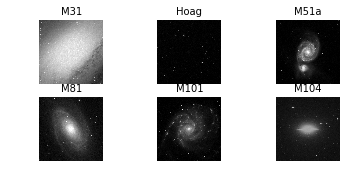

In [4]:
pl.figure(1)
pl.clf()
vmin=0.15
vmax=0.9
k=1

yt=0.99
fs=10
for i in range(6):
    pl.subplot(3,3,1+i)
    if i==5:
        k=0.7
    pl.imshow(I0_all[i]*k,cmap='gray',vmin=vmin,vmax=vmax)
    pl.title(lst_img[i],fontsize=fs,y=yt)
    pl.axis("off")

#pl.subplots_adjust(wspace=-.1,hspace=0.12)
#pl.savefig('imgs/images.png',dpi=200,bbox_inches='tight',pad_inches=.005)

In [4]:
X_test = image.extract_patches_2d(np.pad(I_all[0], (1,1), 'mean'), (3, 3)) # padding, first image is the testing image
#y_test = image.extract_patches_2d(I0_all[0], (1, 1)) 
y_test = np.reshape(I0_all[0],(I0_all[0].shape[0] * I0_all[0].shape[1], 1))

#test_patches = np.reshape(test_patches, (32, 1024)) # reshaping to row_vectors
print(X_test.shape)
print(y_test.shape)
#test_patches

(1048576, 3, 3)
(1048576, 1)


In [5]:
X_train = np.array([image.extract_patches_2d(np.pad(I_all[i], (1,1), 'mean'), (3, 3)) for i in range(1, nb_img)]) # padding array and starting from 2 image for training
X_train = np.reshape(X_train, (X_train.shape[0] * X_train.shape[1], 3, 3))
y_train = np.array([image.extract_patches_2d(I0_all[i], (1, 1)) for i in range(1, nb_img)])
y_train = np.reshape(y_train, (y_train.shape[0] * y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(5242880, 3, 3)
(5242880, 1)


In [6]:
# Reshaping to format which CNN expects (batch, height, width, channels)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1).astype('float32')

#y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1).astype('float32')
#y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 1).astype('float32')

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(5242880, 3, 3, 1)
(5242880, 1)
(1048576, 3, 3, 1)
(1048576, 1)


In [7]:
from tensorflow.python import keras
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout

# Your Code Here
model = Sequential()
model.add(Conv2D(256, (3, 3), input_shape=(X_train.shape[1], X_train.shape[2], 1), activation='relu'))
#model.add(Conv2D(12, kernel_size=(3, 3), input_shape=(3, 3, 1), activation='relu')) # padding = "same",
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(12, (2, 2), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 1, 256)         2560      
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 19,073
Trainable params: 19,073
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])

model.fit(X_train, y_train,
          batch_size=8392,
          epochs=10,
          validation_split = 0.2)

Train on 4194304 samples, validate on 1048576 samples
Epoch 1/10
4194304/4194304 [==============================] - 15s 4us/step - loss: 7.6081e-04 - mean_squared_error: 7.6081e-04 - val_loss: 3.8756e-04 - val_mean_squared_error: 3.8756e-04
Epoch 2/10
4194304/4194304 [==============================] - 5s 1us/step - loss: 2.3597e-04 - mean_squared_error: 2.3597e-04 - val_loss: 3.8240e-04 - val_mean_squared_error: 3.8240e-04
Epoch 3/10
4194304/4194304 [==============================] - 5s 1us/step - loss: 2.3255e-04 - mean_squared_error: 2.3255e-04 - val_loss: 3.7771e-04 - val_mean_squared_error: 3.7771e-04
Epoch 4/10
4194304/4194304 [==============================] - 5s 1us/step - loss: 2.2981e-04 - mean_squared_error: 2.2981e-04 - val_loss: 3.7129e-04 - val_mean_squared_error: 3.7129e-04
Epoch 5/10
4194304/4194304 [==============================] - 6s 1us/step - loss: 2.2746e-04 - mean_squared_error: 2.2746e-04 - val_loss: 3.6825e-04 - val_mean_squared_error: 3.6825e-04
Epoch 6/10
4194

In [10]:
# Save the model
#model.save('models/restoreCNN.h5')

# Final evaluation of the model
#metrics = model.evaluate(X_test, y_test, verbose=True)

# Producing a restored image
y_out = model.predict(X_test, verbose=1)

#print("Metrics(Test loss & Test Accuracy): ")
#print(metrics)

degImage = I_all[0]
orgImage = I0_all[0]
resImage = np.reshape(y_out, degImage.shape)
mse_deg = deconv.mse(orgImage, degImage)
mse_res = deconv.mse(orgImage, resImage)
print(mse_deg, mse_res)
print(-10*np.log10(mse_deg), -10*np.log10(mse_res))

1048576/1048576 [==============================] - 15s 14us/step
0.0007148695231733165 0.0005288392377583114
31.45773217690899 32.76676329411743


In [11]:
I = degImage
I0= orgImage
itmax=100
I_rl,mselist_rl=deconv.richardson_lucy_path(I,PSF,I0,itmax)
nit=mselist_rl.argmin()+1

# final estimation
Irec=deconv.richardson_lucy(I,PSF,nit)

mseRL=deconv.mse(Irec,I0) 
print(mseRL)
print(-10*np.log10(mseRL))
print(nit)

0.0006930184084957589
31.592552291660482
1


In [32]:
# final estimation
Irec=deconv.richardson_lucy(I,PSF,1)

mseRL=deconv.mse(Irec,I0) 
print(mseRL)
print(-10*np.log10(mseRL))

0.0006927046963029132
31.59451867983882


(-0.5, 1023.5, 1023.5, -0.5)

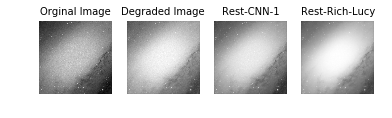

In [15]:
pl.figure(1)
pl.clf()

pl.subplot(1,4,1)
pl.imshow(orgImage, cmap='gray')
pl.title("Orginal Image",fontsize=fs)
pl.axis("off")

pl.subplot(1,4,2)
pl.imshow(degImage, cmap='gray')
pl.title("Degraded Image",fontsize=fs)
pl.axis("off")

pl.subplot(1,4,3)
pl.imshow(resImage, cmap='gray')
pl.title("Rest-CNN-1",fontsize=fs)
pl.axis("off")

pl.subplot(1,4,4)
pl.imshow(Irec, cmap='gray')
pl.title("Rest-Rich-Lucy",fontsize=fs)
pl.axis("off")